In [1]:
import numpy as np
import argparse
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar
from skimage.filters import median
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening, thin
from skimage.exposure import histogram
import skimage
from skimage.draw import rectangle, rectangle_perimeter
import math
import cv2
import numpy as np
from skimage.measure import find_contours
from scipy.signal import find_peaks
from skimage.filters import median, gaussian, threshold_otsu

from skimage.color import rgb2gray, rgb2hsv, rgba2rgb
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import canny, match_template
from skimage.filters import threshold_otsu, threshold_sauvola, threshold_local, threshold_niblack
from skimage.transform import hough_line, hough_line_peaks
from skimage.util import random_noise
from skimage.measure import find_contours
from skimage.draw import rectangle, rectangle_perimeter
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as mpatch
from matplotlib.pyplot import bar
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import math as m
import numpy as np
from skimage.color import rgb2gray, rgb2hsv
from scipy import fftpack
from scipy.signal import convolve2d
from skimage.util import random_noise
from skimage.filters import median, gaussian, threshold_otsu
from skimage.filters import roberts, sobel, sobel_h, scharr
from skimage.exposure import rescale_intensity, equalize_hist
from skimage.morphology import binary_erosion, binary_dilation, binary_closing, binary_opening, skeletonize, thin
from skimage import img_as_ubyte
from skimage.io import imread, imshow
from skimage.filters import gaussian, threshold_otsu
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line, rotate
import skimage.io as io

import matplotlib.patches as mpatch

In [2]:
def adjust_rotation(image):
    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(image > 0))
    
    angle = cv2.minAreaRect(coords)[-1]
    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)
    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle

    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),flags=cv2.INTER_AREA     , borderMode=cv2.BORDER_REPLICATE)

    return rotated


In [3]:

def deskew(binary):
    blur = gaussian(binary, 3)

    # canny edges in scikit-image
    edges = canny(blur)

    # hough lines
    hough_lines = probabilistic_hough_line(edges)

    # hough lines returns a list of points, in the form ((x1, y1), (x2, y2))
    # representing line segments. the first step is to calculate the slopes of
    # these lines from their paired point values
    slopes = [(y2 - y1) / (x2 - x1) if (x2 - x1) else 9999 for (x1, y1), (x2, y2) in hough_lines]

    # it just so happens that this slope is also y where y = tan(theta), the angle
    # in a circle by which the line is offset
    rad_angles = [np.arctan(x) for x in slopes]

    # and we change to degrees for the rotation
    deg_angles = [np.degrees(x) for x in rad_angles]

    # which of these degree values is most common?
    histo = np.histogram(deg_angles, bins=180)

    # correcting for 'sideways' alignments
    rotation_angle = histo[1][np.argmax(histo[0])]
    rotation_angle = int(rotation_angle)
    print(rotation_angle)
    '''
    if rotation_angle > 45:
        rotation_number = -(90 - rotation_angle)
    elif rotation_angle < -45:
        rotation_number = 90 - abs(rotation_angle)
    '''
    # show_images([gray,normalize,edges], ["gray", "bin", "edges"])
    rotated = rotate((np.logical_not(normalize)), rotation_angle, resize=True,
                     mode='constant', cval=0).astype(np.uint8)
    # show_images([gray])
    gray = rotate(gray, rotation_angle, resize=True, mode='constant', cval=255)
    return rotated, gray


In [4]:
def show_images(images,titles=None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [5]:
# binarize the image withe the best between the regular threshold mean and the otsu threshold value
def binarizeImage(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    return gray

In [6]:
# remove elements from array that are close to each other with the (cozy value as the var of diiference)
def closer(arr,cozy):
    result = []
    result.append(arr[0])
    for i in range(1,len(arr)-1):
        if arr[i]-result[-1]>cozy:
            result.append(arr[i])
    return result  

#  segment lines and plot the line histogram
def lineSegmenter(img,plot):
    rows=np.sum(img,1)
    y_pos = np.arange(len(rows))
    peaks=np.logical_and(rows>10, rows<1000)
    peaks=y_pos[peaks]
    peaks=closer(peaks,4)

    lines=[]
    for i in range(len(peaks)):
        if(i==len(peaks)-1):
            continue
        lines.append(img[peaks[i]:peaks[i+1],:])

    if(plot==True):
        plt.barh(y_pos, rows, align='center', alpha=0.5)
        plt.xlabel('Sum of pixels')
        plt.title('Row Contribution')
        plt.show()

    return lines

def wordSegmenter(line):
    words=[]
    for i in line:
        peaks=[]
        print(i.shape)
        for x in range(i.shape[1]):
            value=0
            for y in range(i.shape[0]):
                value+=i[y,x]
            if(value>3):
                peaks.append(x)
        peaks=closer(peaks,3)

        for z in range(len(peaks)):
            if(z==len(peaks)-1):
                continue
            words.append(i[:,peaks[z]:peaks[z+1]]) 
    
    return words



In [7]:
# CCA APPROACH TESTED
def CCA(binary):
    # Perform CCA on the mask
    labeled_image = skimage.measure.label(binary, connectivity=2, return_num=True, background=0)
    components = skimage.measure.regionprops(labeled_image[0])
    thisdict = {}
    sorted_notes_images = []
    index = 0
    keys = []
    boxes = []
    areas_over_bbox = []
    for component in components:
        if component.area > 0:
            minR, minC, maxR, maxC = component.bbox
            thisdict[minR] = []
            thisdict[minR].append(binary[minR:maxR + 2, minC:maxC + 2])
            thisdict[minR].append(component.bbox)
            thisdict[minR].append(component.area / component.bbox_area)
            keys.append(str(index))
            index += 1
    print(thisdict.keys())
    for key in sorted(thisdict.keys()):
        sorted_notes_images.append(thisdict[key][0])
        boxes.append(thisdict[key][1])
        areas_over_bbox.append(thisdict[key][2])
    return components, sorted_notes_images, boxes, areas_over_bbox


def componentsAreas(components):
    area = []
    for component in components:
        area.append(component.area)
    return np.array(area)


# CCA Display Components TESTED
def displayComponents(binary, components):
    # takes ski.image.regionProps output
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(binary)
    for component in components:
        #if component.area > 100:
            # take regions with large enough areas
            # draw rectangle around segmented coins
            # print("orientation of component:",component.orientation)
        minR, minC, maxR, maxC = component.bbox
        rect = mpatch.Rectangle((minC, minR), maxC - minC, maxR - minR, fill=False, edgecolor='red', linewidth=2)
            # show_images([component.image], ["el sorraaa"])
        ax.add_patch(rect)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    
def segmentBoxesInImage(boxes, image_to_segment):
    notes_with_lines = []
    showcase_image = image_to_segment.copy()
    for box in boxes:
        [Ymin, Xmin, Ymax, Xmax] = box
        # print(box)
        rr, cc = rectangle_perimeter(start=(Ymin, Xmin), end=(Ymax, Xmax), shape=image_to_segment.shape)
        showcase_image[np.min(rr):np.max(rr), np.min(cc):np.max(cc)] = 255  # set color white
        notes_with_lines.append(image_to_segment[np.min(rr):np.max(rr), np.min(cc):np.max(cc)])

    notes_with_lines = np.array(notes_with_lines, dtype=object)
    return notes_with_lines, showcase_image

In [8]:
def showHist2(histogramImg):
    plt.figure()
    bar(histogramImg[1] * 255, histogramImg[0], width=0.8, align='center')

def showHist(img):
    # An "interface" to matplotlib.axes.Axes.hist() method
    plt.figure()
    imgHist = histogram(img, nbins=256)
    bar(imgHist[1].astype(np.uint8), imgHist[0], width=0.8, align='center')
    plt.show()


In [9]:
def removeHLines(bin):
    hproj = np.sum(bin, 1)

    # Create output image same height as text, 500 px wide
    m = np.max(hproj)
    w = bin.shape[1]
    result = np.zeros((hproj.shape[0], w))

    # Draw a line for each row
    for row in range(bin.shape[0]):
        cv2.line(result, (0, row), (int(hproj[row] * w / m), row), (255, 255, 255), 1)

    show_images([bin, result], ['binarized', 'horizontal projection'])

    # r, c = result.shape
    # for i in range(r):
    #     if np.sum(result[i]) > 255 * 480:
    #         bin[i, :] = 0

    return result

In [10]:

def deskew(gray):
    # image = imread( filename, as_grey=True)
    # threshold to get rid of extraneous noise
    image = gray.copy()
    # OTSU
    # thresh = threshold_otsu(image)
    # SAUVOLA
    thresh = threshold_otsu(image)
    # NIBLACK
    # thresh = threshold_niblack(image, window_size=25, k=0.8)
    # LOCAL
    # bin1 =  threshold_local(image, 3, 'mean')
    # func = lambda arr: arr.mean()
    # thresh = threshold_local(image, 11, 'generic', param=func)

    # print(thresh)
    normalize = image > thresh
    show_images([normalize], ["binary"])
    # gaussian blur
    blur = gaussian(normalize, 3)

    # canny edges in scikit-image
    edges = canny(blur)

    # hough lines
    hough_lines = probabilistic_hough_line(edges)

    # hough lines returns a list of points, in the form ((x1, y1), (x2, y2))
    # representing line segments. the first step is to calculate the slopes of
    # these lines from their paired point values
    slopes = [(y2 - y1) / (x2 - x1) if (x2 - x1) else 9999 for (x1, y1), (x2, y2) in hough_lines]

    # it just so happens that this slope is also y where y = tan(theta), the angle
    # in a circle by which the line is offset
    rad_angles = [np.arctan(x) for x in slopes]

    # and we change to degrees for the rotation
    deg_angles = [np.degrees(x) for x in rad_angles]

    # which of these degree values is most common?
    histo = np.histogram(deg_angles, bins=180)

    # correcting for 'sideways' alignments
    rotation_angle = histo[1][np.argmax(histo[0])]
    rotation_angle = int(rotation_angle)
    print(rotation_angle)
    '''
    if rotation_angle > 45:
        rotation_number = -(90 - rotation_angle)
    elif rotation_angle < -45:
        rotation_number = 90 - abs(rotation_angle)
    '''
    # show_images([gray,normalize,edges], ["gray", "bin", "edges"])
    rotated = rotate((np.logical_not(normalize)), rotation_angle, resize=True,
                     mode='constant', cval=0).astype(np.uint8)
    # show_images([gray])
    gray = rotate(gray, rotation_angle, resize=True, mode='constant', cval=255)
    return rotated, gray


In [38]:
def segmentImages(rgbimage):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the edges in the image using canny detector
    edges = cv2.Canny(gray, 50, 200)
    # Detect points that form a line
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(edges, theta=tested_angles)

    # Generating figure 1
    # fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    # ax = axes.ravel()

    min_dist=int(0.15*edges.shape[0])
    indices=np.zeros((3,2))
    # ax[0].imshow(edges, cmap=cm.gray)
    origin = np.array((0, edges.shape[1]))
    #print("origin:",origin)
    i=0
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d,min_distance=min_dist)):
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        indices[i][0]=int(y0)
        indices[i][1]=int(y1)
        i+=1
        #print(y0,y1)
        #ax[0].plot(origin, (y0, y1), '-r')
        
    print("Lines indices: ", indices)
    #ax[0].set_xlim(origin)
    #ax[0].set_ylim((edges.shape[0], 0))
    #ax[0].set_axis_off()
    #ax[0].set_title('Detected lines')

    #plt.tight_layout()
    #plt.show()
    indices=np.sort(indices,axis=0)
    # print(indices)
    # Show result
    img_scanned = edges[int(indices[0][0]):int(indices[1][0]),:]
    img_handwritten=edges[int(indices[1][0]):int(indices[2][1]),:]

    return img_scanned, img_handwritten

Lines indices:  [[ 302.  281.]
 [2892. 2871.]
 [ 891.  870.]]


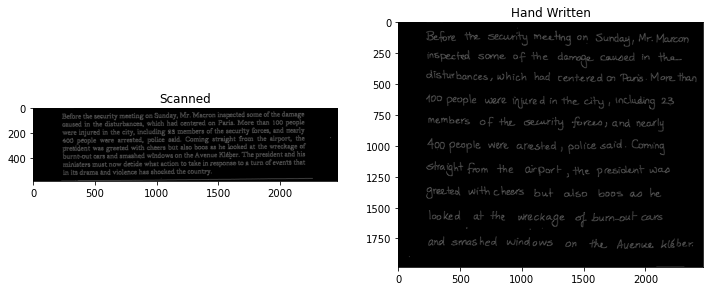

In [39]:
img = cv2.imread('1.png', cv2.IMREAD_COLOR)

img_scanned, img_handwritten =segmentImages(img)
show_images([img_scanned, img_handwritten],["Scanned", "Hand Written"])